In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [2]:
import numpy as np
import torch
import json
from equistore import Labels, TensorBlock, TensorMap
from torch_builder import TensorBuilder
import ase.io
from itertools import product
from torch_cg import ClebschGordanReal
from torch_hamiltonians import fix_pyscf_l1, dense_to_blocks, blocks_to_dense, couple_blocks, decouple_blocks, hamiltonian_features
import matplotlib.pyplot as plt
from rascal.representations import SphericalExpansion
import copy

In [3]:
import sys
sys.path.insert(0,'/Users/divya/new-hamiltonian/equistore-examples')
from utils.librascal import  RascalSphericalExpansion, RascalPairExpansion
from utils.acdc_mini import acdc_standardize_keys, cg_increment, cg_combine

In [4]:
frames = ase.io.read("../data/hamiltonian/water-hamiltonian/water_coords_1000.xyz",":20")
for f in frames:
    f.cell = [100,100,100]
    f.positions += 50

In [5]:
#jorbs = json.load(open('data/water-hamiltonian/water_orbs.json', "r"))
jorbs = json.loads(json.load(open('../data/hamiltonian/water-hamiltonian/water_orbs.json', "r")))
orbs = {}
zdic = {"O" : 8, "H":1}
for k in jorbs:
    orbs[zdic[k]] = jorbs[k]

In [6]:
hams = np.load("../data/hamiltonian/water-hamiltonian/water_saph_orthogonal.npy", allow_pickle=True)[:len(frames)]
# NO NEED TO CORRECT L1 ORDER FOR SAPH ORTHOGONALIZED MATRICES...
#for i, f in enumerate(frames):
#    hams[i] = fix_pyscf_l1(hams[i], f, orbs)

In [7]:
cg = ClebschGordanReal(5)

## Manipulate Hamiltonian into blocks

In [8]:
blocks = dense_to_blocks(hams, frames, orbs)
fock_bc = couple_blocks(blocks, cg)

## Feature computation

In [10]:
rascal_hypers = {
    "interaction_cutoff": 2.5,
    "cutoff_smooth_width": 0.5,
    "max_radial": 4,
    "max_angular": 3,
    "gaussian_sigma_type": "Constant",
    "compute_gradients":  False,
}

spex = RascalSphericalExpansion(rascal_hypers)
rhoi = spex.compute(frames)

In [11]:
pairs = RascalPairExpansion(rascal_hypers)
gij = pairs.compute(frames)

In [12]:
rho1i = acdc_standardize_keys(rhoi)
rho1i.keys_to_properties(['species_neighbor'])
gij =  acdc_standardize_keys(gij)

In [13]:
rho2i = cg_increment(rho1i, rho1i, lcut=4, other_keys_match=["species_center"], clebsch_gordan=cg)

In [14]:
rho3i = cg_increment(rho2i, rho1i, lcut=4, other_keys_match=["species_center"], clebsch_gordan=cg)

In [15]:
rho1ij = cg_increment(rho1i, gij, lcut=4, other_keys_match=["species_center"], clebsch_gordan=cg)

In [16]:
rho2ij = cg_increment(rho2i, gij, lcut=4, other_keys_match=["species_center"], clebsch_gordan=cg)

In [17]:
ham_feats = hamiltonian_features(rho2i, rho1ij)

# Pytorch Model

In [76]:
class LinearModel(torch.nn.Module):
    def __init__(self, coupled_blocks, features, weights=None, intercepts=None):
        super().__init__()
        self.coupled_blocks = coupled_blocks
        self.features = features
        self.weights = {}
        if weights==None:
            for idx_fock, block_fock in self.coupled_blocks:
                block_type, ai, ni, li, aj, nj, lj, L = idx_fock
                parity= (-1)**(li+lj+L)
                size = self.features.block(block_type=block_type, spherical_harmonics_l=L,inversion_sigma=parity, 
                                       species_center=ai, species_neighbor=aj).values.shape[2]
                self.weights[idx_fock] = torch.nn.Parameter(torch.zeros(size, dtype=torch.float64))
            
        else: 
            self.weights = weights
            
        if intercepts is not None:
            self.intercepts = intercepts 
            
        else:
            self.intercepts = None
         
    def forward(self, features):
        k = []
        pred_blocks = []
        for (idx, wts) in self.weights.items():
            #print(wts)
            block_type, ai, ni, li, aj, nj, lj, L = idx
            k.append(list(idx))
            parity= (-1)**(li+lj+L)
            X = self.features.block(block_type=block_type, spherical_harmonics_l=L,inversion_sigma=parity, 
                                   species_center=ai, species_neighbor=aj)
            X_new = torch.from_numpy(X.values.reshape(-1, X.values.shape[2]))
            #print(idx, wts.shape, X.values.shape, X_new.shape)
            if self.intercepts is not None:
                Y = X_new @ wts + self.intercepts[idx]
            else:
                Y = X_new @ wts
            
            newblock = TensorBlock(
                        values=Y.reshape((-1, 2 * L + 1, 1)),
                        samples=X.samples,
                        components=[Labels(
                            ["mu"], np.asarray(range(-L, L + 1), dtype=np.int32).reshape(-1, 1)
                        )],
                        properties= Labels(["values"], np.asarray([[0]], dtype=np.int32))
                    )
            pred_blocks.append(newblock) 
        
        keys = Labels(('block_type', 'a_i', 'n_i', 'l_i', 'a_j', 'n_j', 'l_j', 'L'), np.asarray(k, dtype=np.int32))
        pred_fock = TensorMap(keys, pred_blocks)
        return(pred_fock)
        ### add direct eigenvalue prediction here as well
    
    def parameters(self):
        for idx, wts in self.weights.items():
            yield wts        

In [19]:
#loss functions
def mse_full(fock, pred_blocks, frame, orbs):
    predicted = blocks_to_dense(decouple_blocks(pred_blocks), frame, orbs)
    mse_loss = torch.empty(len(frame))
    for i in range(len(frame)):
        mse_loss[i] = (torch.linalg.norm(fock[i]-predicted[i]))**2/len(fock[i])
        #print("from mse", i, fock[i], mse_loss[i])
    return torch.mean(mse_loss)

def mse_eigvals(fock, pred_blocks, frame, orbs):
    predicted = blocks_to_dense(decouple_blocks(pred_blocks), frame, orbs)
    evanorm = torch.empty(len(frame))
    for i in range(len(frame)):
        evanorm[i] = torch.mean((torch.linalg.eigvalsh(fock[i]) - torch.linalg.eigvalsh(predicted[i]))**2)/len(fock[i])
    return torch.mean(evanorm)

# For single frame

In [24]:
i_frame = frames[0]
i_ham = hams[0] 

i_feats = ham_feats.slice(Labels(names=["structure"], values=np.asarray(range(1), dtype=np.int32).reshape(-1,1)) ),
i_focks = fock_bc.slice(Labels(names=["structure"], values=np.asarray(range(1), dtype=np.int32).reshape(-1,1)) )

### Testing the model with weights from equistore

In [25]:
weights = np.load('model_weights.npy', allow_pickle=True)[()]
intercepts = np.load('model_intercepts.npy', allow_pickle=True)[()]

In [40]:
model = LinearModel(i_focks, i_feats[0], weights=weights, intercepts=intercepts)
print(f"the model contains {len(list(model.parameters()))} parameters")

pred = model(i_feats[0])

the model contains 8 parameters


In [41]:
loss = mse_full([torch.from_numpy(i_ham.astype(np.float64))], pred, [i_frame], orbs)
print(torch.sqrt(loss))

tensor(2.2401e-08)


### Training with loss on full Hamiltonian

In [44]:
model = LinearModel(i_focks, i_feats[0])
optimizer = torch.optim.Adam(model.parameters(), lr=0.8)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15000, gamma=0.01)

all_losses = []
for epoch in range(30000):
    optimizer.zero_grad()
    pred = model(i_feats[0])
    loss = mse_full([torch.from_numpy(i_ham.astype(np.float64))], pred, [i_frame], orbs)
    loss.backward()
    
    optimizer.step()
    scheduler.step()
    
    all_losses.append(loss.item())

    if epoch % 1000 == 0:
        print(epoch, loss.item())

0 0.5252602696418762
1000 0.012743351981043816
2000 0.0009104941273108125
3000 0.0004536648339126259
4000 0.0001806190120987594
5000 4.313429235480726e-05
6000 4.5091414904163685e-06
7000 1.2962941298155783e-07
8000 5.750348530675353e-10
9000 5.51659466805493e-13
10000 1.0363525401412802e-15
11000 6.924302173203997e-16
12000 2.7620166811098473e-16
13000 1.2831288130602425e-15
14000 5.017923764696962e-16
15000 1.2516748798386645e-15
16000 7.331997659563213e-16
17000 7.650610690859694e-16
18000 6.778596624408496e-16
19000 1.2144707575755323e-15
20000 3.0993205531786787e-16
21000 1.1254265248745424e-15
22000 3.050919502385792e-16
23000 6.548782821533012e-16
24000 7.493389729146271e-16
25000 8.609914149503408e-16
26000 5.553639810704193e-16
27000 7.258299969800576e-16
28000 8.755619698298908e-16
29000 3.0843709510552323e-16


Text(0, 0.5, '$MSE_{full}$')

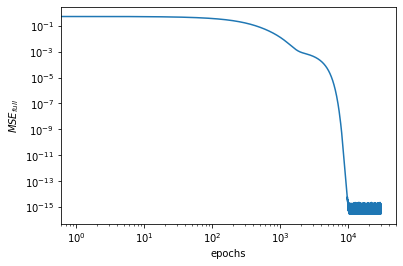

In [46]:
plt.loglog(all_losses)

plt.xlabel("epochs")
plt.ylabel("$MSE_{full}$")

### Training with loss on eigenvalues

In [47]:
model = LinearModel(i_focks, i_feats[0])
optimizer = torch.optim.Adam(model.parameters(), lr=0.8)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10000, gamma=0.01)

eigval_losses = []
for epoch in range(30000):
    optimizer.zero_grad()
    pred = model(i_feats[0])
    eigval_loss = mse_eigvals([torch.from_numpy(i_ham.astype(np.float64))], pred, [i_frame], orbs)
    eigval_loss.backward()
    optimizer.step()
    
    eigval_losses.append(eigval_loss.item())

    if epoch % 1000 == 0:
        print(epoch, eigval_loss.item())
    
    scheduler.step()

0 0.07313249260187149
1000 0.00026996646192856133
2000 5.596232099946974e-08
3000 2.7129460719479796e-14
4000 2.6957009893616504e-15
5000 9.686255856238392e-16
6000 1.296768690488997e-15
7000 3.0241524142196087e-15
8000 4.065183858482403e-15
9000 4.32505907241418e-15
10000 4.389821093978875e-15
11000 6.49571885436549e-16
12000 1.186469648284318e-15
13000 1.9500161695210376e-15
14000 1.2387532863491818e-15
15000 1.461137551486062e-15
16000 1.8999177705809715e-15
17000 2.0405432392753145e-15
18000 2.1838470261488756e-15
19000 6.112263439253442e-15
20000 1.3493779068429615e-15
21000 1.7296043264809573e-15
22000 1.7296043264809573e-15
23000 1.7296043264809573e-15
24000 1.7296043264809573e-15
25000 5.531865770003837e-16
26000 5.531865770003837e-16
27000 3.3424373261281472e-15
28000 3.3424373261281472e-15
29000 2.224811445302225e-15


Text(0, 0.5, '$MSE_{\\epsilon}$')

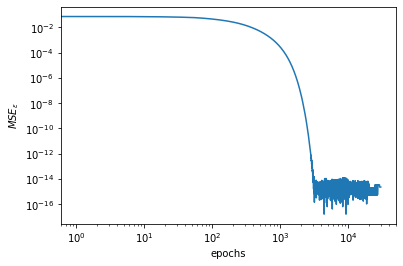

In [48]:
plt.loglog(eigval_losses)

plt.xlabel("epochs")
plt.ylabel("$MSE_{\epsilon}$")

In [49]:
pred_coupled = model(ham_feats)
rmse_full = torch.sqrt(mse_full([torch.from_numpy(i_ham.astype(np.float64))], pred, [i_frame], orbs))
print(rmse_full)

tensor(0.8015, grad_fn=<SqrtBackward0>)


# Train and test on multiple frames

### Split into train and test set

In [52]:
train_frames = frames[:10]
train_hams = hams[:10]
train_feats = ham_feats.slice(Labels(names=["structure"], values=np.asarray(range(10), dtype=np.int32).reshape(-1,1)) ),
train_focks = fock_bc.slice(Labels(names=["structure"], values=np.asarray(range(10), dtype=np.int32).reshape(-1,1)) )

In [53]:
test_frames = frames[10:]
test_hams = hams[10:]
test_feats = ham_feats.slice(Labels(names=["structure"], values=np.asarray(range(10,20), dtype=np.int32).reshape(-1,1)) ),
test_focks = fock_bc.slice(Labels(names=["structure"], values=np.asarray(range(10,20), dtype=np.int32).reshape(-1,1)) )

In [77]:
model = LinearModel(train_focks, train_feats[0])
optimizer = torch.optim.Adam(model.parameters(), lr=0.8)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=18000, gamma=0.1)

all_losses = []
for epoch in range(60000):
    optimizer.zero_grad()
    pred = model(train_feats[0])
    loss = mse_full(torch.from_numpy(train_hams.astype(np.float64)), pred, train_frames, orbs)
    loss.backward()
    optimizer.step()
    #scheduler.step()
    
    all_losses.append(loss.item())

    if epoch % 1000 == 0:
        print(epoch, loss.item()) 

0 0.4856087565422058
1000 0.011796231381595135
2000 0.0016981108346953988
3000 0.0008754763985052705
4000 0.00041460557258687913
5000 0.00021487593767233193
6000 0.0001303936296608299
7000 8.119090489344671e-05
8000 4.8168494686251506e-05
9000 2.6553079806035385e-05
10000 1.4343451766762882e-05
11000 8.596015504735988e-06
12000 6.251683771552052e-06
13000 5.31848172613536e-06
14000 4.880197138845688e-06
15000 4.605988124239957e-06
16000 4.393911694933195e-06
17000 4.214641194266733e-06
18000 4.0585632632428315e-06
19000 3.921019924746361e-06
20000 3.798854550041142e-06
21000 3.6896090023219585e-06
22000 3.591296263039112e-06
23000 3.502285835565999e-06
24000 3.4212166610814165e-06
25000 3.347016900079325e-06
26000 3.2787679629109334e-06
27000 3.2157236091734376e-06
28000 3.157209675919148e-06
29000 3.1027229852043092e-06
30000 3.0517410323227523e-06
31000 3.003920028277207e-06
32000 2.9589023142762017e-06
33000 2.916380708484212e-06
34000 2.876100779758417e-06
35000 2.8378622118907515e

Text(0, 0.5, '$MSE_{full}$')

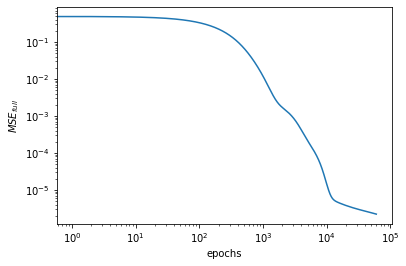

In [78]:
plt.loglog(all_losses)

plt.xlabel("epochs")
plt.ylabel("$MSE_{full}$")

In [79]:
pred = model(test_feats[0])
test_loss = mse_full(torch.from_numpy(test_hams.astype(np.float64)), pred, test_frames, orbs)
test_loss_eigvals = mse_eigvals(torch.from_numpy(test_hams.astype(np.float64)), pred, test_frames, orbs)

In [80]:
print(torch.sqrt(test_loss), torch.sqrt(test_loss_eigvals))

tensor(0.3345, grad_fn=<SqrtBackward0>) tensor(0.0138, grad_fn=<SqrtBackward0>)
